# Vehicle damage detection

## Introduction and Project Goal

### Problem statement

In the automotive insurance and repair industry, assessing and visualizing vehicle repairs is a important and is often subjective and manual process.

Customers and insurers find it difficult to understand the repair estimate and  struggle to visualize what a damaged vehicle will look like after repairs.

Current methods rely on verbal descriptions, estimates or generic reference images, which fail to account for the specific context (lighting, angle, color) of the actual damaged vehicle.

### Goal/Objective
The objective is to develop an AI based detection, estimation and repair system capable of reconstructing the damaged cars to its original look.

#### Phasewise Goals:

Phase 1: Implement a computer vision pipeline to automatically detect and localize damage (dents, scratches, breakage) on vehicle images without human intervention.

Phase 2: Convert detection data into precise pixel-level segmentation masks to isolate the damage from the rest of the vehicle.

Phase 3: Fine-tune a generative model (ControlNet) to generate images that looks like the repaired car.

In [8]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 133.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Phase 1
## Dataset Overview and Preparation

Documenting the data ensures reproducibility and transparency.

### Data Source
The data for detection is taken from roboflow
https://universe.roboflow.com/make-and-model-recognition/damage-severity-h7fgy/dataset/1

#### Dataset Size
**Total Image count**: 2000 Images

**Training dataset**: 1400 Images

**classes**: car-part-crack, detachment, flat-tire, glass-crack, lamp-crack, minor-deformation, moderate-deformation, paint-chips, scratches, severe-deformation, side-mirror-crack

**Data Preprocessing**

Auto-Orient: Applied

Resize: Stretch to 640x640

**Augmentations**: No augmentations were applied

In [9]:
from roboflow import Roboflow
import os

from google.colab import userdata

# This line is only specific to Google Colab for reteriving the key from secret
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
WORKSPACE_ID = "make-and-model-recognition"
PROJECT_ID = "damage-severity-h7fgy"
VERSION_NUMBER = 1
DATASET_FORMAT = "yolov8"

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace(WORKSPACE_ID).project(PROJECT_ID)

dataset_version = project.version(VERSION_NUMBER)

print(f"Successfully connected to project: {PROJECT_ID} (Version {VERSION_NUMBER})")

loading Roboflow workspace...
loading Roboflow project...
Successfully connected to project: damage-severity-h7fgy (Version 1)


In [10]:
DOWNLOAD_DIR = "car_damage_dataset_yolov8"

dataset_info = dataset_version.download(
    model_format="yolov8",
    location=DOWNLOAD_DIR
)



Extracting Dataset Version Zip to car_damage_dataset_yolov8 in yolov8:: 100%|██████████| 4012/4012 [00:00<00:00, 7391.39it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
data_yaml_path = os.path.join(DOWNLOAD_DIR, 'data.yaml')

print("Dataset Download Complete!")
print(f"Data saved to: {os.path.abspath(DOWNLOAD_DIR)}")
print(f"YOLOv8 Configuration file (data.yaml) ready at: {data_yaml_path}")

Dataset Download Complete!
Data saved to: /content/car_damage_dataset_yolov8
YOLOv8 Configuration file (data.yaml) ready at: car_damage_dataset_yolov8/data.yaml


Display few images from the dataset.

Displaying a few sample images from the training set:


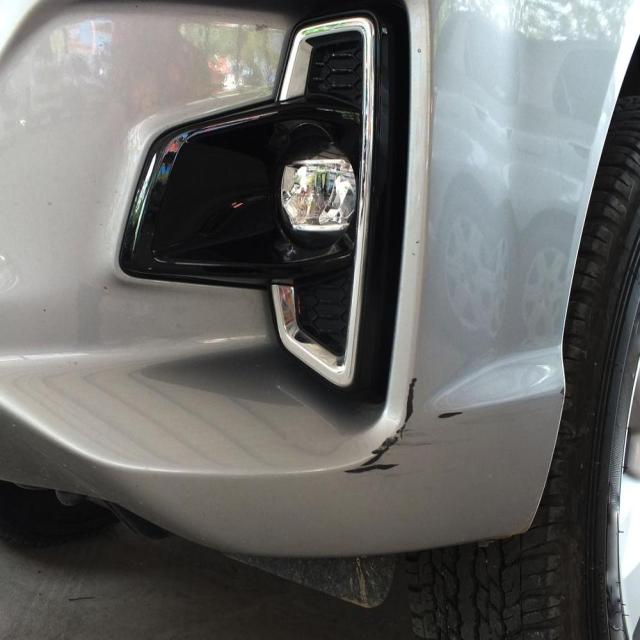

Image: 002136_jpg.rf.c2ff32edd3157cb31bdbb493f2460da7.jpg


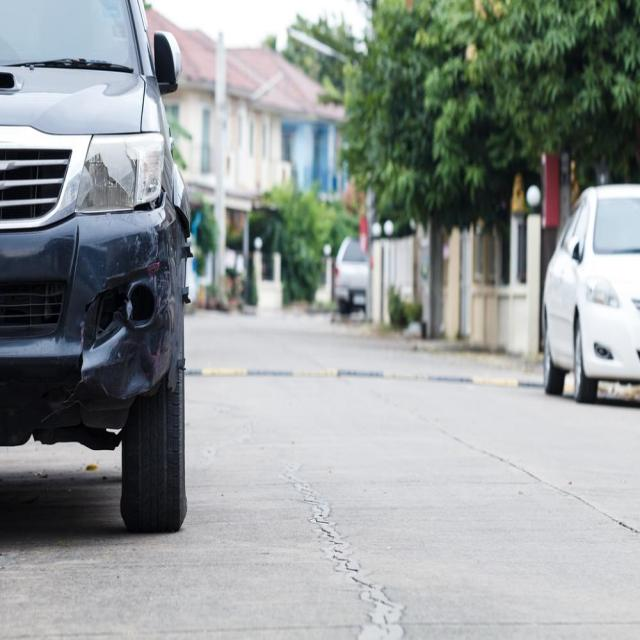

Image: 000108_jpg.rf.fa5ccf14e2d0f46facdcf7485a6ffe6c.jpg


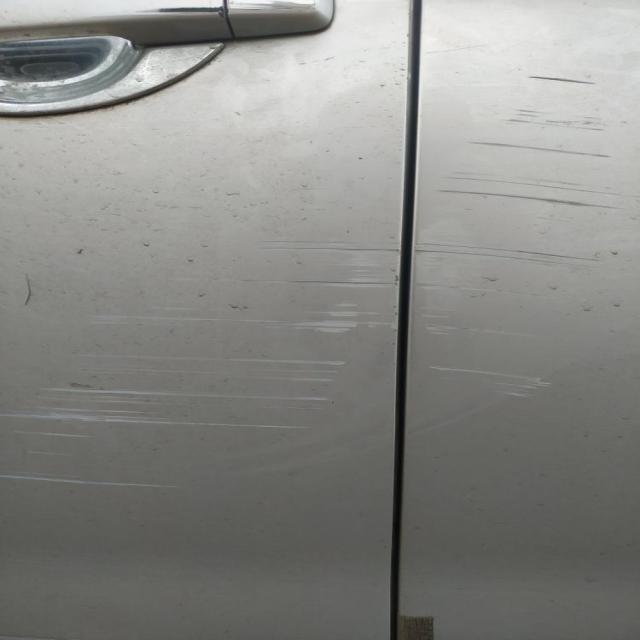

Image: 002108_jpg.rf.26e50799f6951fc7d6c7b5b955f13e15.jpg


In [14]:
import os
from IPython.display import Image, display

# Assuming DOWNLOAD_DIR is defined and contains the dataset
train_images_path = os.path.join(DOWNLOAD_DIR, 'train', 'images')

image_files = [f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:
    print("Displaying a few sample images from the training set:")
    # Display up to 3 random images
    for i, img_file in enumerate(image_files):
        if i >= 3:
            break
        img_path = os.path.join(train_images_path, img_file)
        display(Image(filename=img_path, width=300))
        print(f"Image: {img_file}")
else:
    print("No image files found in the training directory.")


## Loading Pre-trained Model Weights (Transfer Learning)
Using 'yolov8s.pt' (Small) for small size and high speed.

> Previously this was tried with a nano version. It resulted in good indicator for 3 classes flat-tire: (mAP50: 0.959, mAP50-95: 0.823), glass-crack: (mAP50: 0.966, mAP50-95: 0.838), lamp-crack: (mAP50: 0.671, mAP50-95: 0.498). But failed to perform well for the other classes. To mitigate this I used a larger model (small). It has more parameters (72 layers, 11M parameters) and hence might achieve higher accuracy



### Finetuning the Yolov8 model by freezing the backbone layers of the model

![YOLOv8 Architecture](https://yolov8.org/wp-content/uploads/2024/01/What-is-YOLOv8-1.webp)
*Image of YOLOv8 taken from the Ultralytics website*

The reason behind freezing is that the initial layers have already learned fundamental features (edges, textures, colors) from a massive dataset, and these features are useful for detecting damage to vehicle as it also involves detecting edges, texture of the vehicle and the color of the vehicle. I only want to train the final layers to adapt the general features to specific damage classes.

## YOLO Training Part 1

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

print("Starting YOLOv8 Fine-Tuning...")

results = model.train(
    data='/content/car_damage_dataset_yolov8/data.yaml',
    epochs=100,
    imgsz=640,
    batch=64,
    name='damage_detector_v1',
    patience=20,
    optimizer='AdamW',
    freeze=10
    )

best_weights_path = 'runs/detect/damage_detector_v1/weights/best.pt'

Starting YOLOv8 Fine-Tuning...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car_damage_dataset_yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=damage_detector_v12, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap

I ran the model for 100 epoch with 10 freeze layers.

In [5]:
import os
# If you have saved the training weights create directories and upload the weights
os.makedirs('/content/runs/detect/damage_detector_v1/weights', exist_ok=True)
os.makedirs('/content/runs/detect/phase2_unfrozen_refinement/weights/', exist_ok=True)

## Validation and Performance Metrics

In [17]:
def validate_yolo_model(model_path):
    """
    Loads a YOLO model and performs validation to evaluate its performance metrics.

    This function initializes a YOLO model using the provided weight file, runs the
    validation process (using the dataset defined in the model's YAML configuration),
    and extracts key object detection metrics. It prints a formatted summary of
    mAP, Precision, Recall, and F1 Score to the console and checks against a
    defined PRD target (89% mAP).

    Args:
        model_path (str): The file path to the trained YOLO model weights
                          (e.g., 'runs/detect/train/weights/best.pt').

    Returns:
        None: The function prints evaluation results directly to standard output
              and does not return a value.

    Raises:
        FileNotFoundError: If the provided `model_path` does not exist.
        AttributeError: If the YOLO metrics object structure differs from expected
                        attributes (box.map, box.p, etc.).
    """
    model = YOLO(model_path)
    print("Running final model validation...")
    metrics = model.val()

    mAP50 = metrics.box.map50
    mAP50_95 = metrics.box.map

    precision = metrics.box.p[0] if metrics.box.p is not None and len(metrics.box.p) > 0 else 0.0
    recall = metrics.box.r[0] if metrics.box.r is not None and len(metrics.box.r) > 0 else 0.0
    f1_score = metrics.box.f1[0] if metrics.box.f1 is not None and len(metrics.box.f1) > 0 else 0.0

    print(f"\n--- Model Evaluation Results ---")
    print(f"Overall mAP (0.50-0.95): {mAP50_95 * 100:.2f}%")
    print(f"mAP50: {mAP50 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1_score * 100:.2f}%")
    print(f"PRD Target (89%+): {'MET' if mAP50_95 >= 0.89 else 'MISSED'}")

In [18]:
from ultralytics import YOLO
best_model = YOLO("/content/runs/detect/damage_detector_v1/weights/best.pt")

validate_yolo_model(best_model)


Running final model validation...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1044.1±546.1 MB/s, size: 50.1 KB)
val: Scanning /content/car_damage_dataset_yolov8/valid/labels... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 1.3Kit/s 0.3s
val: New cache created: /content/car_damage_dataset_yolov8/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 4.9it/s 5.1s
                   all        400        943      0.417      0.344      0.347      0.247
        car-part-crack         62         92      0.314      0.174      0.165      0.079
            detachment          9         10          0          0    0.00445    0.00204
             flat-tire         31         32      0.823      0.875      0.908      0.801
           g

In [19]:
from collections import Counter
input_image_path = '/content/car_damage_dataset_yolov8/test/images/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg'

print("\nRunning Inference and Damage Counting...")
inference_results = best_model.predict(
    source=input_image_path,
    conf=0.50,
    iou=0.7,
    save=True
)

damage_count = Counter()

for result in inference_results:
    detected_class_ids = result.boxes.cls.int().tolist()

    class_names = result.names

    class_id_counts = Counter(detected_class_ids)

    for class_id, count in class_id_counts.items():
        damage_name = class_names[class_id]
        damage_count[damage_name] += count

print("\n--- Final Damage Count Report ---")
if not damage_count:
    print("No damage detected above the confidence threshold.")
else:
    for damage, count in damage_count.items():
        print(f"Detected: {count} instance(s) of '{damage}'")



Running Inference and Damage Counting...

image 1/1 /content/car_damage_dataset_yolov8/test/images/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg: 640x640 1 lamp-crack, 1 moderate-deformation, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict

--- Final Damage Count Report ---
Detected: 1 instance(s) of 'moderate-deformation'
Detected: 1 instance(s) of 'lamp-crack'


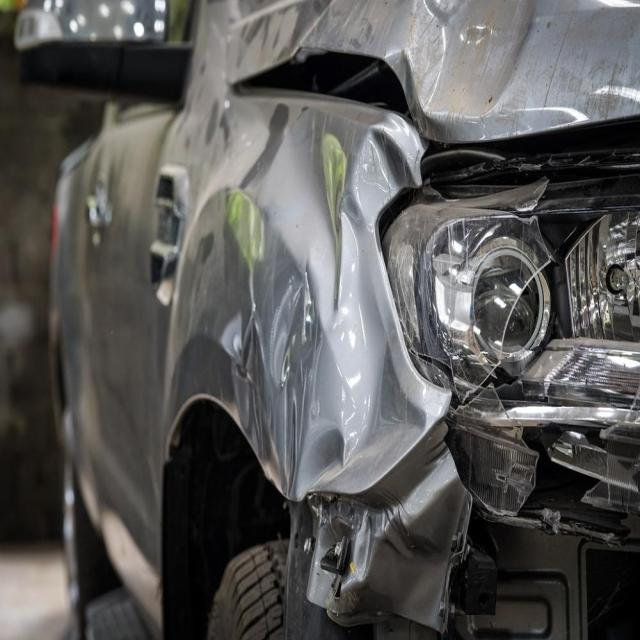

In [20]:
from IPython.display import Image
Image(input_image_path)

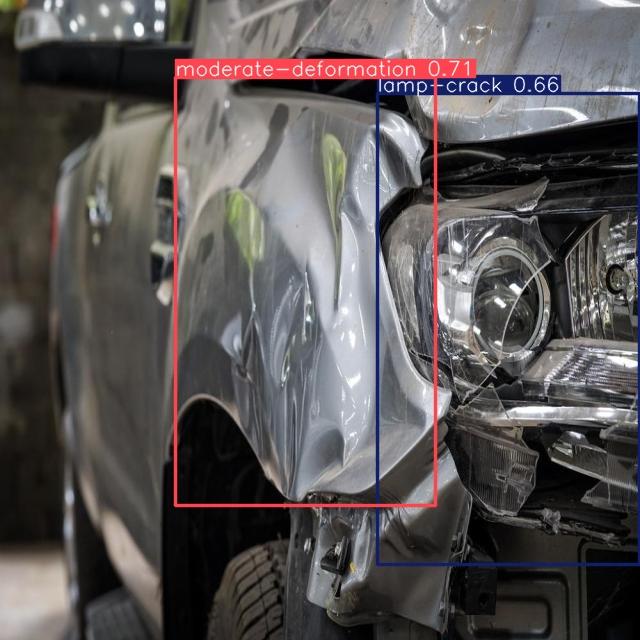

In [21]:
Image('/content/runs/detect/predict/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg')

The same was tried for YOLOv8n but there are significant performance improvement in identifying class specific to vehicle damage.

**scratches**: mAP50 increased from 0.349(YOLOv8n) to 0.359. Precision jumped from 0.477(YOLOv8n) to 0.377. While precision slightly dipped, the Recall is higher and the mAP50 is slightly better.

**moderate-deformation**: mAP50 increased from 0.315(YOLOv8n) to 0.370. A gain which shows the larger model is better at recognizing this kind of damage.

**car-part-crack**: mAP50 increased from 0.0636(YOLOv8n) to 0.164. Over 150% improvement which indicates the model is finally starting to recognize this complex damage.

Other classes like

**minor-deformation**: mAP50 0.0642. Recall is 8.6%.

**paint-chips**: mAP50 0.13. Recall is 15.8%.

To overcome the shortcomings I decided to unfreeze the best fit model weights and train over longer epoch. This can refine the model.

## Training Part 2: Fine tune models by unfreezing all layers

In [ ]:
from ultralytics import YOLO

BEST_FROZEN_WEIGHTS = '/content/runs/detect/damage_detector_v1/weights/best.pt'
model = YOLO(BEST_FROZEN_WEIGHTS)

print("\nPhase 2: Training ALL layers (Unfrozen Refinement)...")

results = model.train(
    data=data_yaml_path,
    imgsz=640,
    batch=64,
    epochs=200,
    freeze=0,
    name="phase2_unfrozen_refinement"
)

print("\nPhase 2 refinement training started. This should lead to further improvements, especially in subtle classes.")


Phase 2: Training ALL layers (Unfrozen Refinement)...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car_damage_dataset_yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/best (1).pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=phase2_unfrozen_refinement, nbs=64, nms=False, opset=None, optimize=

## Model Evaluation After Unfreezing all Layers

In [ ]:
phase_2_best_model = YOLO("/content/runs/detect/phase2_unfrozen_refinement/weights/best.pt")

validate_yolo_model(phase_2_best_model)

Running final model validation...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1122.3±407.6 MB/s, size: 45.9 KB)
val: Scanning /content/car_damage_dataset_yolov8/valid/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 802.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 3.6it/s 6.9s
                   all        400        943      0.519       0.39      0.404      0.297
        car-part-crack         62         92       0.41      0.264      0.264      0.115
            detachment          9         10          0          0    0.00311   0.000933
             flat-tire         31         32      0.927      0.844      0.911      0.856
           glass-crack         79         80      0.974      0.947      0.984      

#### Comparison and interpretation of the result

In [ ]:
# TODO: change the interpretation of the res

There is a significant improvement in the model after the second round of training.

mAP50-95 improved from 24.7%(freeze) to 29.7% which shows that the model is better in making precise bounding boxes at IoU thresholds.

mAP50 improved from	34.7%	to 40.4% which shows it is better at finding and locating the damage in the vehicle.

Precision improved from	41.6%	to 51.9% which shows that false positives are reduced.

Recall increased from	34.3%	to 39.0% shows that the model is less likely to miss the damage in the vehicle.


#### Class wise breakdown after training

|Class Name          |Instances|Phase 1 mAP50|Phase 2 mAP50|Change      |Insight                                                                                                                                                                                                                   |
|--------------------|---------|-------------|-------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|glass-crack         |80       |0.969        |0.984        |↑1.5%       |Near-perfect. (P=0.974, R=0.947)                                                                                                                                                                                          |
|flat-tire           |32       |0.908        |0.911        |↑0.3%       |Excellent.                                                                                                                                                                                                                |
|lamp-crack          |68       |0.694        |0.703        |↑0.9%       |                                                                                                                                           |
|moderate-deformation|180      |0.370        |0.433        |↑6.3%       |Very The model can now reliably find moderate damage.                                                                                                                                                 |
|scratches           |302      |0.359        |0.365        |↑0.6%       |Modest gain. This complex class needs more training or data.                                                                                                                                                              |
|car-part-crack      |92       |0.164        |0.264        |↑100 points!|The model can now consistently identify complex cracks in the vehicle.                                                                                                                                                     |
|paint-chips         |76       |0.132        |0.135        |↑0.3%       |Slight gain. Still difficult due to small size/texture.                                                                                                                                                                   |
|severe-deformation  |18       |0.137        |0.176        |↑3.9%       | low instances.                                                                                                                                                                                      |
|minor-deformation   |81       |0.0642       |0.116        |↑5.2 points!|Significant percentage gain, but still low.                                                                                                 |                                                                                                                                                                                       |
|side-mirror-crack   |4        |0.0189       |0.499        |↑48.0%      |This might be an anomaly.|


## Phase 2: Pixel level segmentation masks to isolate the damage from the rest of the vehicle

**Model**: SAM (Segment Anything Model)

**Role**: Segmentation Refinement.

**Task**: Takes the YOLO bounding boxes as prompts and generates precise, pixel-perfect segmentation masks.

**Output**: A binary black-and-white mask image (White = Damage area, Black = Safe).

![Sam architecture](https://raw.githubusercontent.com/facebookresearch/sam2/main/assets/model_diagram.png)
*The diagram is taken from official facebookresearch/segment-anything git repo*

In [4]:
# This is not specific to image manipulation.
# This is a utility function for handling image upload to
# the notebook
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from PIL import Image

def run_samples_on_user_image(custom_process_function):
  """
    Creates and displays an interactive image upload widget that triggers a custom
    processing function upon file selection.

    This function sets up a single-file upload button and an output display area.
    When an image is uploaded, it clears any previous results, normalizes the
    file data (handling different ipywidgets versions), and invokes the provided
    callback function within the output context.

    Args:
        custom_process_function (callable): A function to execute when an image is uploaded.
            This function must accept exactly two arguments:
            1. filename (str): The name of the uploaded file (e.g., 'photo.jpg').
            2. content (bytes): The raw binary content of the uploaded file.

    Returns:
        None: The widget (VBox containing button and output) is rendered directly
        to the notebook output area via IPython.display.
    """
  uploader = widgets.FileUpload(accept='image/*', multiple=False)

  # The container where results will appear
  out = widgets.Output()

  def on_upload_change(change):
      if not change.new:
          return

      # Clear the previous result
      out.clear_output()

      # Extract File
      if isinstance(change.new, dict):
          filename = next(iter(change.new.keys()))
          content = change.new[filename]['content']
      else:
          uploaded_file = change.new[0]
          filename = uploaded_file['name']
          content = uploaded_file['content'].tobytes() if hasattr(uploaded_file['content'], 'tobytes') else uploaded_file['content']

      with out:
          custom_process_function(filename, content)

  uploader.observe(on_upload_change, names='value')

  # Display the button and the output area together
  return display(widgets.VBox([uploader, out]))

In [29]:
from ultralytics import YOLO
import os

def detect_damage_and_get_boxes(image_path, confidence_threshold=0.5, iou_threshold=0.7):
    """
    Loads the finetuned YOLOv8 model, runs inference on an image, and extracts
    the bounding box coordinates for detected damage.

    Args:
        image_path (str): The path to the input image.
        confidence_threshold (float): Confidence score threshold for detections.
        iou_threshold (float): IoU threshold for Non-Maximum Suppression.

    Returns:
        list: A list of dictionaries, where each dictionary contains the
              detected class name and its bounding box coordinates (xyxy format).
    """
    # Load the best model from Phase 2
    best_model_path_phase2 = '/content/runs/detect/phase2_unfrozen_refinement/weights/best.pt'

    model = YOLO(best_model_path_phase2)

    print(f"Running inference on: {image_path}")
    results = model.predict(
        source=image_path,
        conf=confidence_threshold,
        iou=iou_threshold,
        verbose=False, # Suppress verbose output from predict
        save=True # Change this to True if you need the prediction to be saved to display
    )

    detected_boxes_info = []
    for result in results:
        if result.boxes:
            for box in result.boxes:
                class_id = int(box.cls[0])
                class_name = model.names[class_id]
                # xyxy format: [x1, y1, x2, y2]
                coords = box.xyxy[0].tolist()
                detected_boxes_info.append({
                    'class': class_name,
                    'confidence': float(box.conf[0]),
                    'bbox_xyxy': [round(c, 2) for c in coords]
                })
    return detected_boxes_info



In [34]:
from PIL import Image
def run_damage_detection(name, content):
  """
    Processes raw image content to detect damage and prints the results to standard output.

    This function converts binary image content into a PIL Image object, passes it
    to a detection model, and iterates through any findings to display class,
    confidence, and bounding box coordinates.

    Args:
        name (str): The filename or identifier associated with the image.
        content (bytes): The raw binary data of the image file.

    Returns:
        None: This function prints detection details directly to the console
              and does not return a value.
    """
  example_image_path = Image.open(io.BytesIO(content))
  print("--- Running damage detection ---")
  damage_detections = detect_damage_and_get_boxes(example_image_path)

  if damage_detections:
      print("Detected damage and bounding box coordinates:")
      for detection in damage_detections:
          print(f"  Class: {detection['class']}, Confidence: {detection['confidence']:.2f}, Bounding Box (xyxy): {detection['bbox_xyxy']}")
          print(detection)
  else:
      print("No damage detected in the example image above the specified thresholds.")

run_samples_on_user_image(run_damage_detection)




> Make sure save is True if the prediction is to be displayed. It is by default turned to False as it would take up space in the mask generation



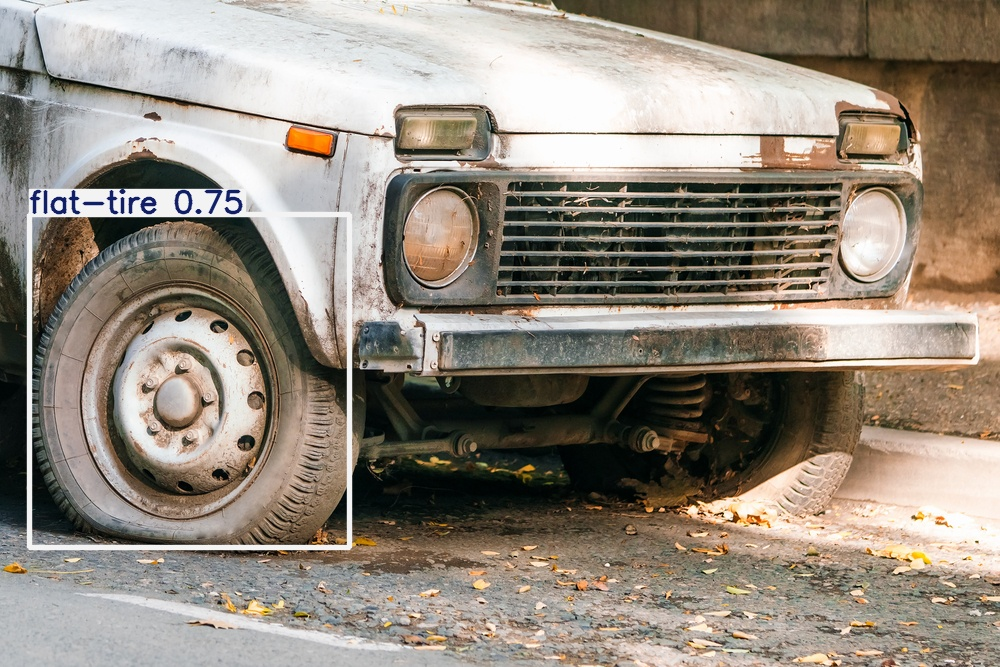

In [35]:
from IPython.display import Image
Image('/content/runs/detect/predict4/image0.jpg')

Pipeline this to a SAM for segmentation

In [36]:
! pip install torch torchvision torchaudio
! pip install opencv-python Pillow numpy
! pip install 'git+https://github.com/facebookresearch/segment-anything.git'
! mkdir -p sam_weights
! wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P sam_weights/


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0h82ypw8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0h82ypw8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6dcbf796ec79ee7b51765499612f858c0690f28c49eb86e61215c2c4e7c8fff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccey1sja/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [37]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2 # Used for mask dilation

# Import the necessary SAM components
from segment_anything import sam_model_registry, SamPredictor

# Global Model Paths
SAM_CHECKPOINT_PATH = 'sam_weights/sam_vit_h_4b8939.pth'
SAM_MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Loading SAM model on device: {DEVICE}")
sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
SAM_PREDICTOR = SamPredictor(sam)
print("SAM Predictor Ready.")

Loading SAM model on device: cuda
SAM Predictor Ready.


In [38]:
from PIL import Image
import numpy as np
import cv2 # Used for mask dilation
from segment_anything import SamPredictor # Import SamPredictor explicitly

def box_to_pixel_mask(image_pil: Image.Image, detection_results: list, sam_predictor: SamPredictor, dilation_kernel_size=5) -> Image.Image:
    """
    Converts YOLO bounding boxes to a precise binary segmentation mask using SAM.

    Args:
        image_pil (Image.Image): The input damaged car image (PIL format).
        detection_results (list): List of dictionaries from detect_damage_and_get_boxes.
        sam_predictor (SamPredictor): Initialized SAM predictor object.
        dilation_kernel_size (int): Size of the kernel for mask dilation (to soften edges).

    Returns:
        Image.Image: A single-channel binary mask (L mode) for ControlNet.
    """
    if not detection_results:
        # If no damage detected, return a completely black mask
        return Image.new('L', image_pil.size, 0)

    # Convert PIL image to RGB NumPy array for SAM
    image_rgb = np.array(image_pil.convert("RGB"))

    # Set the image for SAM (encodes the image once)
    sam_predictor.set_image(image_rgb)

    # Initialize an empty mask of the same size as the image
    combined_mask = np.zeros(image_rgb.shape[:2], dtype=bool)

    # Iterate through each detection and generate a mask for each box individually
    for detection in detection_results:
        # SAM expects [x_min, y_min, x_max, y_max]
        input_box = np.array([detection['bbox_xyxy']]) # Pass a single box, wrapped in an array

        # SAM Inference for a single box
        # Use multimask_output=False for a single, focused mask per box
        masks, _, _ = sam_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box, # Pass only one box at a time
            multimask_output=False,
        )
        # Add the current box's mask to the combined mask
        # masks[0] because multimask_output=False returns a (1, H, W) mask array
        combined_mask = np.logical_or(combined_mask, masks[0])

    # Convert boolean mask to 0 (black) and 255 (white)
    mask_array = (combined_mask * 255).astype(np.uint8)

    # Dilate the Mask (Recommended for Inpainting)
    if dilation_kernel_size > 0:
        kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
        # Use cv2.dilate to slightly expand the mask boundaries
        mask_array = cv2.dilate(mask_array, kernel, iterations=1)

    # Convert back to PIL Image (single channel 'L' for grayscale mask)
    return Image.fromarray(mask_array)


In [43]:
def run_mask_generation(name, content):
  example_image_path = Image.open(io.BytesIO(content))
  image_pil = Image.open(io.BytesIO(content)).convert("RGB")
  detection_res = detect_damage_and_get_boxes(example_image_path)
  mask_image = box_to_pixel_mask(
          image_pil=image_pil,
          detection_results=detection_res,
          sam_predictor=SAM_PREDICTOR,
          dilation_kernel_size=5
      )
  display(mask_image)

run_samples_on_user_image(run_mask_generation)

In [44]:
! pip install -q transformers accelerate peft

In [45]:
! pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-cnotm1e5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-cnotm1e5
  Resolved https://github.com/huggingface/diffusers.git to commit 6290fdfda40610ce7b99920146853614ba529c6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-py3-none-any.whl size=4589080 sha256=b1d1c4dc84255b71218159ccdb6de75cf783d4f78b93a81a195f5b95ad83c032
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvvlyf6g/wheels/23/0f/7d/f97813d265ed0e599a78d83afd4e1925740896ca79b46cccfd
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.2
    Uninstalling diffusers-0.35.2:
      Successfully uninstalled diffusers-0.35.2


## Phase 3 ControlNet LoRA Fine-Tuning

**Base Model**: Stable Diffusion v1.5 (specifically runwayml/stable-diffusion-v1-5).

**ControlNet**: A trainable copy of the SD UNet's encoder layers, designed to accept the mask input.

**LoRA (Low-Rank Adaptation)**: instead of retraining the massive ControlNet (360M+ params), we inject small rank-decomposition matrices (rank=16) into the attention layers. This makes training faster.

**Training Logic**:The model sees the Damaged Image.It sees the Mask.It receives the text prompt: "a high quality photo of a perfectly repaired car".It learns to denoise the latent image such that the masked area matches the "repaired" concept while the unmasked area stays identical to the input.

upload the  ``` train_controlnet_lora.py```
file from the script folder in the git repo. This is a custom version of lora text to image implementation which can be found in https://github.com/HighCWu/ControlLoRA/blob/main/train_text_to_image_control_lora.

The file is changed to suite this usecase


## Running Inference

New damaged image -> YOLO/SAM -> Mask.

Image + Mask + Prompt -> Trained ControlNet Pipeline.

The ControlNet guides the Stable Diffusion model to generate clean pixels only in the white masked area, showing how the car might look like.

Alternatve approach instead of finetuining controlnet


In [51]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import numpy as np
import torch

def run_inference(init_image, mask_image, prompt="flawless car"):
    """
      Executes a Stable Diffusion ControlNet inpainting pipeline to modify an image based on a mask.

      This function resizes inputs to 512x512, prepares a ControlNet condition image
      where masked pixels are marked as -1.0, and runs inference using the
      'runwayml/stable-diffusion-v1-5' model with the 'lllyasviel/control_v11p_sd15_inpaint' adapter.

      Args:
          init_image (PIL.Image.Image): The source image to be modified.
          mask_image (PIL.Image.Image): A binary mask image where the area to be
              inpainted is defined (usually white for the area to replace).
          prompt (str, optional): The text description guiding the inpainting generation.
              Defaults to "flawless car".

      Returns:
          PIL.Image.Image: The generated inpainted image (resized to 512x512).
      """

    init_image = init_image.resize((512, 512))

    generator = torch.Generator(device="cpu").manual_seed(1)

    mask_image = mask_image.resize((512, 512))


    def make_inpaint_condition(image, image_mask):
      """
        Prepares a control image tensor for ControlNet inpainting by masking specific regions.

        This function normalizes the input image and mask to the [0, 1] range. It then
        sets any pixel falling under the mask (threshold > 0.5) to a value of -1.0,
        which signals the model to inpaint that area. Finally, it rearranges dimensions
        to NCHW format and converts the result to a PyTorch tensor.

        Args:
            image (PIL.Image.Image): The source RGB image to be processed.
            image_mask (PIL.Image.Image): The binary mask image indicating areas to modify.

        Returns:
            torch.Tensor: A tensor of shape (1, 3, H, W) containing the conditioned image data.

        Raises:
            AssertionError: If the height and width of the image and the mask do not match.
        """
      image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
      image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

      assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
      image[image_mask > 0.5] = -1.0  # set as masked pixel
      image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
      image = torch.from_numpy(image)
      return image


    control_image = make_inpaint_condition(init_image, mask_image)

    controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
    )
    pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
    )

    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()

    # generate image
    image = pipe(
        prompt,
        num_inference_steps=20,
        generator=generator,
        eta=1.0,
        image=init_image,
        mask_image=mask_image,
        control_image=control_image,
    ).images[0]

    return image


In [52]:
import ipywidgets as widgets
from IPython.display import display
import io
from PIL import Image

def process_image(name, content):
    print(f"Processing {name}...")
    try:
        image = Image.open(io.BytesIO(content))
        detections = detect_damage_and_get_boxes(image)
        print(detections)

        mask = box_to_pixel_mask(image, detections, SAM_PREDICTOR)

        image.thumbnail((300, 300))
        display(image)
        display(mask)

        repaired_car = run_inference(image, mask, "flawless car without dents and flawless paint")
        display(repaired_car)
        print(f"Image size: {image.size}")
    except Exception as e:
        print(f"Error opening image: {e}")

run_samples_on_user_image(process_image)